# 🌳 Chapter 16-18: Trees, BSTs & AVL Trees

Welcome to the fascinating world of **Tree Data Structures** - nature's hierarchy brought to computer science!

This interactive notebook explores:
- **Chapter 16**: Tree fundamentals, traversals, and analysis
- **Chapter 17**: Binary Search Trees (BSTs) with operations and properties
- **Chapter 18**: AVL Trees - self-balancing BSTs with guaranteed performance
- **Interactive Visualizations**: See trees grow, balance, and transform
- **Algorithm Demonstrations**: Insertions, deletions, rotations, and traversals

## 🎯 Learning Objectives

By the end of this notebook, you'll be able to:
- Understand tree terminology and properties (height, balance, completeness)
- Implement and visualize tree traversals (preorder, inorder, postorder, level-order)
- Master BST operations with O(log n) performance analysis
- Apply AVL tree rotations to maintain balance
- Compare tree variants and choose appropriate implementations
- Analyze tree performance across different input sequences

In [1]:
# Import required libraries and setup
import sys
import os
sys.path.append('../')

import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import List, Optional, Any, Dict
import networkx as nx

# Import our tree implementations
from chapter_16_trees.code.tree_implementations import (
    TreeNode, BinaryTree, BinarySearchTree, AVLTree, TreeAnalysis
)
from chapter_17_binary_search_trees.code.bst_implementation import (
    BSTNode, BinarySearchTree as BST17, BSTAnalysis
)
from chapter_18_balanced_trees.code.avl_tree import (
    AVLNode, AVLTree as AVL18
)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries and tree implementations loaded successfully!")
print("🎯 Ready to explore tree data structures!")

# Initialize tree classes
analysis = TreeAnalysis()
bst_analysis = BSTAnalysis()

✅ Libraries and tree implementations loaded successfully!
🎯 Ready to explore tree data structures!


In [2]:
# API Wrapper Functions - Handle inconsistencies across tree implementations
# This layer abstracts away API differences so notebook code can be clean and consistent

def get_tree_size(tree) -> int:
    """Get tree size - handles different method names across implementations"""
    if hasattr(tree, 'count_nodes'):
        return tree.count_nodes()
    elif hasattr(tree, 'size'):
        return tree.size()
    else:
        # Fallback: manually count nodes
        def count_nodes_recursive(node):
            if not node:
                return 0
            return 1 + count_nodes_recursive(node.left) + count_nodes_recursive(node.right)
        return count_nodes_recursive(tree.root if hasattr(tree, 'root') else tree._root)

def get_tree_height(tree) -> int:
    """Get tree height - standardized interface"""
    if hasattr(tree, 'get_height'):
        return tree.get_height()
    elif hasattr(tree, 'height'):
        return tree.height
    else:
        return 0  # Default for empty trees

def is_tree_complete(tree) -> bool:
    """Check if tree is complete - with fallback"""
    if hasattr(tree, 'is_complete'):
        return tree.is_complete()
    else:
        # Basic completeness check using level-order traversal
        if not hasattr(tree, 'root') or not tree.root:
            return True
        
        from collections import deque
        queue = deque([tree.root])
        found_none = False
        
        while queue:
            node = queue.popleft()
            if node is None:
                found_none = True
                continue
            if found_none:
                return False
            queue.append(node.left)
            queue.append(node.right)
        return True

def is_tree_full(tree) -> bool:
    """Check if tree is full - with fallback"""
    if hasattr(tree, 'is_full'):
        return tree.is_full()
    else:
        # Check if every node has 0 or 2 children
        def check_full_recursive(node):
            if not node:
                return True
            # Node must have both children or neither
            if (node.left is None) != (node.right is None):
                return False
            return check_full_recursive(node.left) and check_full_recursive(node.right)
        
        root = tree.root if hasattr(tree, 'root') else tree._root
        return check_full_recursive(root)

def is_tree_balanced(tree) -> bool:
    """Check if tree is height-balanced - with fallback"""
    if hasattr(tree, 'is_balanced'):
        return tree.is_balanced()
    else:
        # Check height balance (difference ≤ 1)
        def check_balance_recursive(node):
            if not node:
                return True, 0
            
            left_balanced, left_height = check_balance_recursive(node.left)
            right_balanced, right_height = check_balance_recursive(node.right)
            
            balanced = left_balanced and right_balanced and abs(left_height - right_height) <= 1
            height = 1 + max(left_height, right_height)
            return balanced, height
        
        root = tree.root if hasattr(tree, 'root') else tree._root
        balanced, _ = check_balance_recursive(root)
        return balanced

def safe_tree_copy(tree):
    """Safely copy a tree - handles missing copy methods"""
    if hasattr(tree, 'copy'):
        return tree.copy()
    else:
        # Manual deep copy for trees without copy method
        def copy_tree_recursive(node):
            if not node:
                return None
            new_node = TreeNode(node.value)
            new_node.left = copy_tree_recursive(node.left)
            new_node.right = copy_tree_recursive(node.right)
            if hasattr(node, 'height'):
                new_node.height = node.height
            return new_node
        
        if hasattr(tree, '__class__'):
            new_tree = tree.__class__()
            if hasattr(tree, 'root'):
                new_tree.root = copy_tree_recursive(tree.root)
            elif hasattr(tree, '_root'):
                new_tree._root = copy_tree_recursive(tree._root)
            return new_tree
        else:
            # Fallback for unknown tree types
            return tree

def tree_traversal(tree, order: str) -> List[Any]:
    """Unified tree traversal interface"""
    order = order.lower()
    if order == 'preorder' or order == 'pre-order':
        return tree.preorder_traversal() if hasattr(tree, 'preorder_traversal') else []
    elif order == 'inorder' or order == 'in-order':
        return tree.inorder_traversal() if hasattr(tree, 'inorder_traversal') else []
    elif order == 'postorder' or order == 'post-order':
        return tree.postorder_traversal() if hasattr(tree, 'postorder_traversal') else []
    elif order == 'levelorder' or order == 'level-order':
        return tree.level_order_traversal() if hasattr(tree, 'level_order_traversal') else []
    else:
        return []

def is_tree_valid_bst(tree) -> bool:
    """Check if tree is a valid BST - handles different method names"""
    if hasattr(tree, 'is_valid_bst'):
        return tree.is_valid_bst()
    elif hasattr(tree, 'is_valid'):
        return tree.is_valid()
    else:
        # Fallback BST validation
        def is_bst_recursive(node, min_val=float('-inf'), max_val=float('inf')):
            if not node:
                return True
            if not (min_val < node.value < max_val):
                return False
            return (is_bst_recursive(node.left, min_val, node.value) and 
                    is_bst_recursive(node.right, node.value, max_val))
        
        root = tree.root if hasattr(tree, 'root') else tree._root
        return is_bst_recursive(root)

print("✅ API wrapper functions loaded - notebook code can now use consistent interfaces!")
print("🎯 All tree operations will work regardless of underlying API differences.")

✅ API wrapper functions loaded - notebook code can now use consistent interfaces!
🎯 All tree operations will work regardless of underlying API differences.


## 🌿 Section 1: Tree Fundamentals

### Tree Terminology

- **Root**: Topmost node (no parent)
- **Leaf**: Node with no children
- **Internal Node**: Node with at least one child
- **Height**: Longest path from root to leaf
- **Depth**: Distance from root to node
- **Balance Factor**: Height difference between subtrees
- **Complete Tree**: All levels filled except possibly last
- **Full Tree**: Every node has 0 or 2 children

=== TREE FUNDAMENTALS ===

Sample Tree Properties:
Height: 3
Size: 10
Is Complete: False
Is Full: False
Is Balanced: True
Number of Leaves: 4

Tree Traversals:
Preorder:  [1, 2, 4, 8, 5, 9, 3, 6, 10, 7]
Inorder:   [8, 4, 2, 9, 5, 1, 6, 10, 3, 7]
Postorder: [8, 4, 9, 5, 2, 10, 6, 7, 3, 1]
Level-order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/var/folders/th/t5bmj7z97kx83tz9dxkwbz0m0000gn/T/ipykernel_90524/2926499346.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


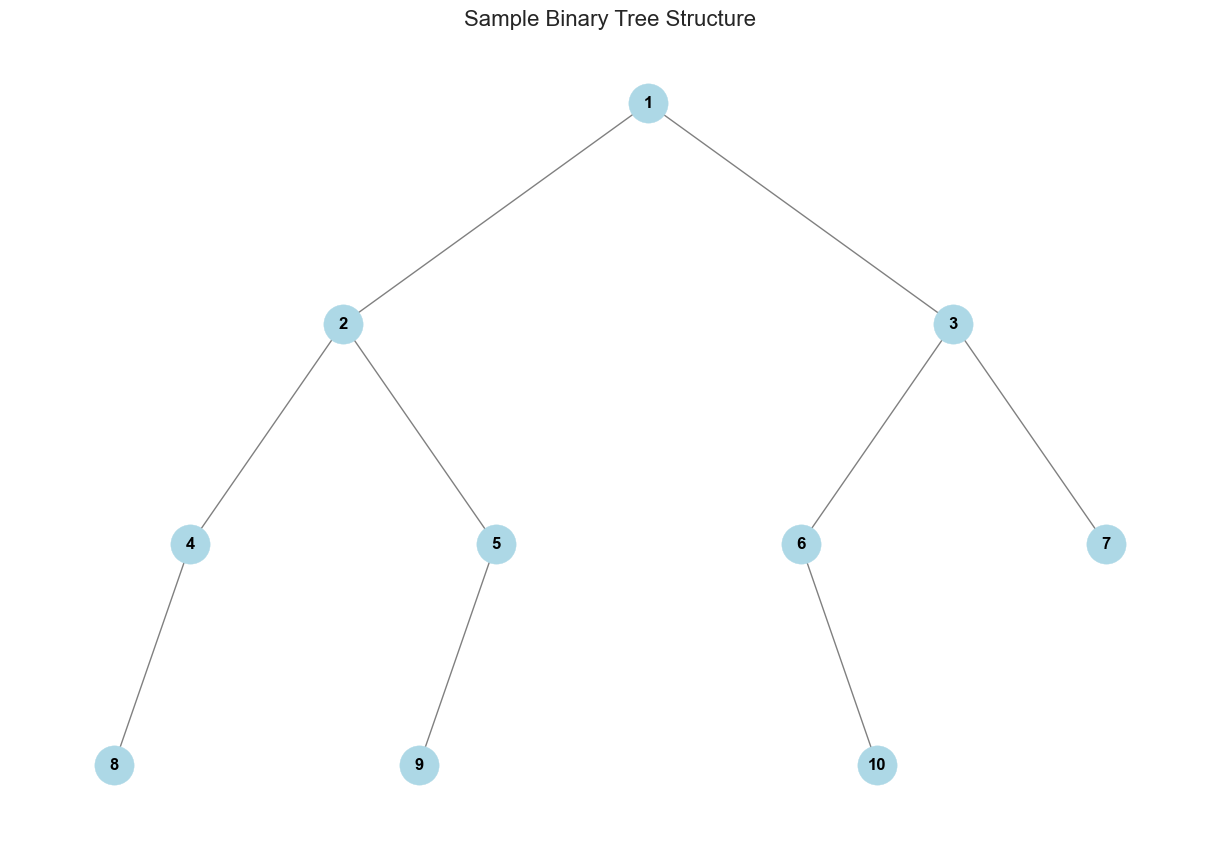


🎯 Key Insights:
- Trees organize hierarchical data efficiently
- Different traversals visit nodes in different orders
- Tree properties affect performance and balance
- Visual representation helps understand tree structure
- Height determines worst-case operation time


In [3]:
# Interactive tree creation and visualization
print("=== TREE FUNDAMENTALS ===\n")

# Create a sample tree for demonstration
def create_sample_tree():
    """Create a sample binary tree for demonstration."""
    # Level 1
    root = TreeNode(1)
    
    # Level 2
    root.left = TreeNode(2)
    root.right = TreeNode(3)
    
    # Level 3
    root.left.left = TreeNode(4)
    root.left.right = TreeNode(5)
    root.right.left = TreeNode(6)
    root.right.right = TreeNode(7)
    
    # Level 4
    root.left.left.left = TreeNode(8)
    root.left.right.left = TreeNode(9)
    root.right.left.right = TreeNode(10)
    
    tree = BinaryTree(root)
    return tree

sample_tree = create_sample_tree()

# Tree properties
print("Sample Tree Properties:")
print(f"Height: {get_tree_height(sample_tree)}")
print(f"Size: {get_tree_size(sample_tree)}")
print(f"Is Complete: {is_tree_complete(sample_tree)}")
print(f"Is Full: {is_tree_full(sample_tree)}")
print(f"Is Balanced: {is_tree_balanced(sample_tree)}")
print(f"Number of Leaves: {sample_tree.count_leaves()}")

# Tree traversals
print("\nTree Traversals:")
print(f"Preorder:  {tree_traversal(sample_tree, 'preorder')}")
print(f"Inorder:   {tree_traversal(sample_tree, 'inorder')}")
print(f"Postorder: {tree_traversal(sample_tree, 'postorder')}")
print(f"Level-order: {tree_traversal(sample_tree, 'levelorder')}")

# Visualize the tree
def plot_tree(tree, title="Binary Tree"):
    """Plot a binary tree using networkx."""
    if tree.root is None:
        print("Empty tree")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create graph
    G = nx.DiGraph()
    pos = {}
    labels = {}
    
    def add_nodes_edges(node, x=0, y=0, dx=1, dy=1, level=0):
        if node is None:
            return
        
        # Position node
        pos[node] = (x, -y)
        labels[node] = node.value
        
        # Add children
        if node.left:
            G.add_edge(node, node.left)
            add_nodes_edges(node.left, x - dx/(2**level), y + dy, dx, dy, level+1)
        
        if node.right:
            G.add_edge(node, node.right)
            add_nodes_edges(node.right, x + dx/(2**level), y + dy, dx, dy, level+1)
    
    add_nodes_edges(tree.root)
    
    # Draw the tree
    nx.draw(G, pos, with_labels=True, labels=labels, 
            node_color='lightblue', node_size=800, 
            font_size=12, font_weight='bold',
            arrows=False, edge_color='gray')
    
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_tree(sample_tree, "Sample Binary Tree Structure")

# Tree analysis
print("\n🎯 Key Insights:")
print("- Trees organize hierarchical data efficiently")
print("- Different traversals visit nodes in different orders")
print("- Tree properties affect performance and balance")
print("- Visual representation helps understand tree structure")
print("- Height determines worst-case operation time")

In [4]:
# Interactive tree traversal explorer
def create_traversal_explorer():
    """Interactive tree traversal demonstration."""
    
    # Create different tree structures
    trees = {
        'Complete': create_sample_tree(),
        'Left Skewed': None,  # Will create dynamically
        'Right Skewed': None,  # Will create dynamically
        'Random': None  # Will create dynamically
    }
    
    tree_selector = widgets.Dropdown(
        options=list(trees.keys()),
        value='Complete',
        description='Tree Type:'
    )
    
    traversal_selector = widgets.Dropdown(
        options=['Preorder', 'Inorder', 'Postorder', 'Level-order'],
        value='Inorder',
        description='Traversal:'
    )
    
    output_area = widgets.Output()
    plot_area = widgets.Output()
    
    def get_current_tree():
        """Get the currently selected tree."""
        tree_type = tree_selector.value
        
        if tree_type == 'Complete':
            return create_sample_tree()
        elif tree_type == 'Left Skewed':
            # Create left-skewed tree
            root = TreeNode(4)
            root.left = TreeNode(3)
            root.left.left = TreeNode(2)
            root.left.left.left = TreeNode(1)
            return BinaryTree(root)
        elif tree_type == 'Right Skewed':
            # Create right-skewed tree
            root = TreeNode(1)
            root.right = TreeNode(2)
            root.right.right = TreeNode(3)
            root.right.right.right = TreeNode(4)
            return BinaryTree(root)
        else:  # Random
            # Create a random tree
            values = list(range(1, 16))
            random.shuffle(values)
            
            # Create BST from random values
            bst = BinarySearchTree()
            for v in values:
                bst.insert(v)
            return bst
    
    def demonstrate_traversal(b):
        with output_area:
            clear_output(wait=True)
            
            tree = get_current_tree()
            traversal = traversal_selector.value
            
            print(f"{traversal} Traversal of {tree_selector.value} Tree")
            print("=" * 50)
            
            # Get traversal result
            if traversal == 'Preorder':
                result = tree.preorder_traversal()
                description = "Root → Left → Right"
            elif traversal == 'Inorder':
                result = tree.inorder_traversal()
                description = "Left → Root → Right (sorted for BST)"
            elif traversal == 'Postorder':
                result = tree.postorder_traversal()
                description = "Left → Right → Root"
            else:  # Level-order
                result = tree.level_order_traversal()
                description = "Level by level, left to right"
            
            print(f"Order: {description}")
            print(f"Result: {result}")
            
            # Additional analysis
            print(f"\nTree Properties:")
            print(f"Height: {get_tree_height(tree)}")
            print(f"Size: {get_tree_size(tree)}")
    
    def visualize_tree(b):
        with plot_area:
            clear_output(wait=True)
            
            tree = get_current_tree()
            
            plt.figure(figsize=(10, 6))
            
            if tree.root is None:
                plt.text(0.5, 0.5, 'Empty Tree', ha='center', va='center', fontsize=16)
                plt.xlim(0, 1)
                plt.ylim(0, 1)
                plt.axis('off')
            else:
                plot_tree(tree, f"{tree_selector.value} Tree Structure")
            
            plt.show()
    
    traverse_button = widgets.Button(description='Show Traversal')
    traverse_button.on_click(demonstrate_traversal)
    
    visualize_button = widgets.Button(description='Visualize Tree')
    visualize_button.on_click(visualize_tree)
    
    # Layout
    controls = widgets.VBox([
        widgets.HBox([tree_selector, traversal_selector]),
        widgets.HBox([traverse_button, visualize_button])
    ])
    
    display(widgets.VBox([controls, widgets.HBox([output_area, plot_area])]))
    
    # Initial demonstration
    demonstrate_traversal(None)
    visualize_tree(None)

print("🌳 Interactive Tree Traversal Explorer")
print("Explore different tree structures and traversal algorithms:")
create_traversal_explorer()

🌳 Interactive Tree Traversal Explorer
Explore different tree structures and traversal algorithms:


## 🔍 Section 2: Binary Search Trees (BSTs)

### BST Properties

- **Binary Tree**: Each node has at most 2 children
- **Search Property**: Left subtree < node < right subtree
- **Operations**: O(log n) average, O(n) worst case
- **Inorder Traversal**: Produces sorted sequence

### BST Operations
- **Search**: Find node with given value
- **Insert**: Add new node maintaining BST property
- **Delete**: Remove node while preserving BST property
- **Successor/Predecessor**: Find next/previous values

=== BINARY SEARCH TREES ===

Building BST with values: [50, 30, 70, 20, 40, 60, 80, 15, 25, 35, 45, 55, 65, 75, 85]
Inserting step by step:
Step 1: Insert 50 -> Height: 0, Size: 1
Step 2: Insert 30 -> Height: 1, Size: 2
Step 3: Insert 70 -> Height: 1, Size: 3
Step 4: Insert 20 -> Height: 2, Size: 4
Step 5: Insert 40 -> Height: 2, Size: 5
Step 6: Insert 60 -> Height: 2, Size: 6
Step 7: Insert 80 -> Height: 2, Size: 7
Step 8: Insert 15 -> Height: 3, Size: 8
Step 9: Insert 25 -> Height: 3, Size: 9
Step 10: Insert 35 -> Height: 3, Size: 10
Step 11: Insert 45 -> Height: 3, Size: 11
Step 12: Insert 55 -> Height: 3, Size: 12
Step 13: Insert 65 -> Height: 3, Size: 13
Step 14: Insert 75 -> Height: 3, Size: 14
Step 15: Insert 85 -> Height: 3, Size: 15

Final BST Properties:
Height: 3
Size: 15
Is BST: True
Is Balanced: True
Min Value: 15
Max Value: 85

Search Operations:
Search 35: Found (path: [50, 30, 40, 35])
Search 60: Found (path: [50, 70, 60])
Search 90: Not found (path: [50, 70, 80, 85])
S

/var/folders/th/t5bmj7z97kx83tz9dxkwbz0m0000gn/T/ipykernel_90524/2926499346.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


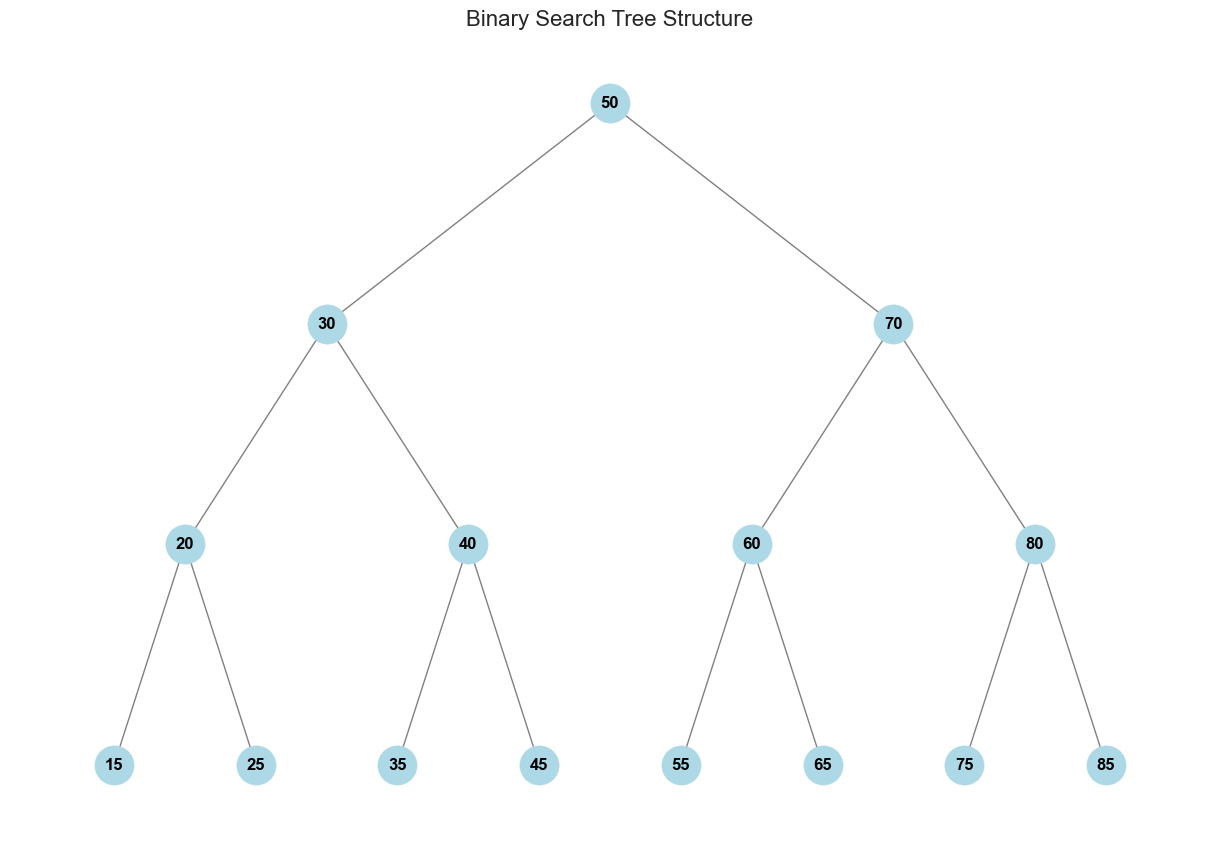


=== BST Performance Analysis ===

Random  : Height= 2, Insert=0.000011s, Search=0.000002s
Sorted  : Height= 6, Insert=0.000007s, Search=0.000001s
Reverse : Height= 6, Insert=0.000005s, Search=0.000001s


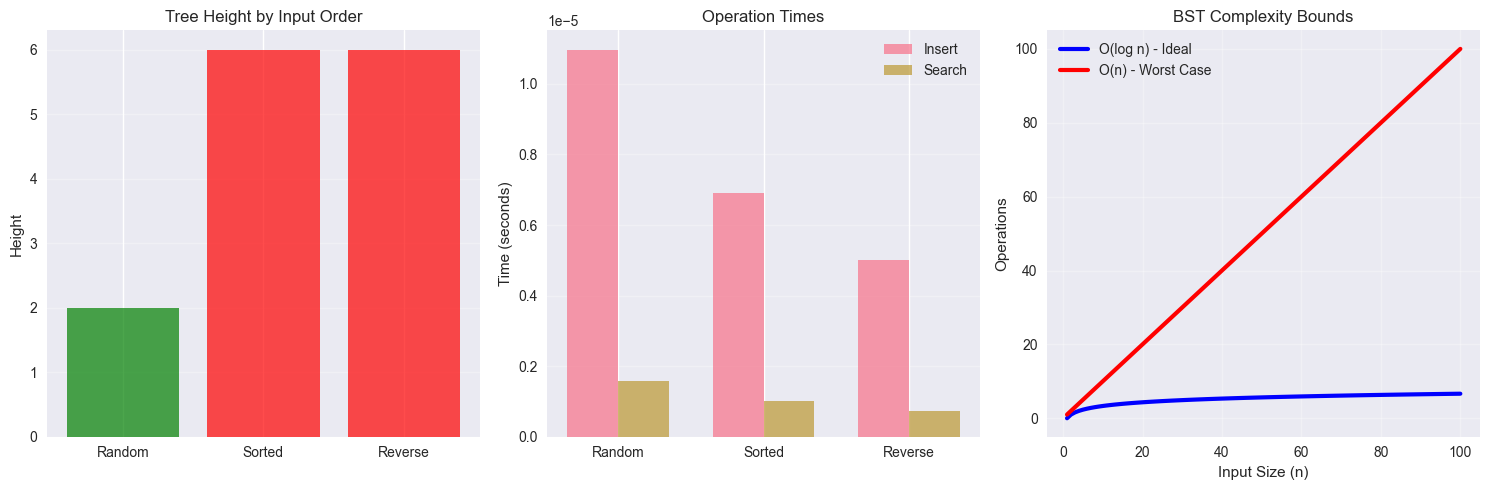


🎯 Key Insights:
- BST performance depends on input order
- Random insertion → O(log n), sorted insertion → O(n)
- Height determines operation time
- Inorder traversal gives sorted sequence
- BSTs require balancing for guaranteed performance


In [5]:
# Interactive BST operations
print("=== BINARY SEARCH TREES ===\n")

# Create and demonstrate BST
bst = BinarySearchTree()

# Insert values that create an interesting tree
values_to_insert = [50, 30, 70, 20, 40, 60, 80, 15, 25, 35, 45, 55, 65, 75, 85]

print("Building BST with values:", values_to_insert)
print("Inserting step by step:")

bst_states = []
for i, val in enumerate(values_to_insert, 1):
    bst.insert(val)
    print(f"Step {i}: Insert {val} -> Height: {bst.get_height()}, Size: {bst.count_nodes()}")
    
    # Store state for animation
    bst_states.append(safe_tree_copy(bst))

print("\nFinal BST Properties:")
print(f"Height: {get_tree_height(bst)}")
print(f"Size: {get_tree_size(bst)}")
print(f"Is BST: {is_tree_valid_bst(bst)}")
print(f"Is Balanced: {is_tree_balanced(bst)}")
print(f"Min Value: {bst.find_min()}")
print(f"Max Value: {bst.find_max()}")

# Demonstrate search
search_values = [35, 60, 90, 10]
print("\nSearch Operations:")
for val in search_values:
    found, path = bst.search_with_path(val)
    status = "Found" if found else "Not found"
    print(f"Search {val}: {status} (path: {path})")

# Demonstrate inorder traversal (should be sorted)
inorder = bst.inorder_traversal()
print(f"\nInorder Traversal (sorted): {inorder}")
print(f"Is sorted: {all(inorder[i] <= inorder[i+1] for i in range(len(inorder)-1))}")

# Visualize the BST
plot_tree(bst, "Binary Search Tree Structure")

# Performance analysis
print("\n=== BST Performance Analysis ===\n")

# Test with different input orders
input_orders = {
    'Random': [50, 30, 70, 20, 40, 60, 80],
    'Sorted': [20, 30, 40, 50, 60, 70, 80],  # Worst case
    'Reverse': [80, 70, 60, 50, 40, 30, 20]  # Worst case
}

performance_results = {}

for order_name, values in input_orders.items():
    test_bst = BinarySearchTree()
    
    # Time insertions
    start = time.time()
    for val in values:
        test_bst.insert(val)
    insert_time = time.time() - start
    
    # Time searches
    search_times = []
    for val in values:
        start = time.time()
        test_bst.search(val)
        search_times.append(time.time() - start)
    avg_search_time = sum(search_times) / len(search_times)
    
    performance_results[order_name] = {
        'height': test_bst.get_height(),
        'insert_time': insert_time,
        'avg_search_time': avg_search_time
    }
    
    print(f"{order_name:8}: Height={test_bst.get_height():2}, "
          f"Insert={insert_time:.6f}s, Search={avg_search_time:.6f}s")

# Visualize performance
plt.figure(figsize=(15, 5))

# Height comparison
plt.subplot(1, 3, 1)
orders = list(performance_results.keys())
heights = [performance_results[o]['height'] for o in orders]
bars = plt.bar(orders, heights, color=['green', 'red', 'red'], alpha=0.7)
plt.title('Tree Height by Input Order')
plt.ylabel('Height')
plt.grid(True, alpha=0.3, axis='y')

# Time comparison
plt.subplot(1, 3, 2)
insert_times = [performance_results[o]['insert_time'] for o in orders]
search_times = [performance_results[o]['avg_search_time'] for o in orders]

x = np.arange(len(orders))
width = 0.35
plt.bar(x - width/2, insert_times, width, label='Insert', alpha=0.7)
plt.bar(x + width/2, search_times, width, label='Search', alpha=0.7)
plt.xticks(x, orders)
plt.ylabel('Time (seconds)')
plt.title('Operation Times')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Theoretical complexity
plt.subplot(1, 3, 3)
n_vals = np.arange(1, 101)
plt.plot(n_vals, np.log2(n_vals), 'b-', label='O(log n) - Ideal', linewidth=3)
plt.plot(n_vals, n_vals, 'r-', label='O(n) - Worst Case', linewidth=3)
plt.xlabel('Input Size (n)')
plt.ylabel('Operations')
plt.title('BST Complexity Bounds')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("- BST performance depends on input order")
print("- Random insertion → O(log n), sorted insertion → O(n)")
print("- Height determines operation time")
print("- Inorder traversal gives sorted sequence")
print("- BSTs require balancing for guaranteed performance")

## ⚖️ Section 3: AVL Trees - Self-Balancing BSTs

### AVL Tree Properties

- **Height-Balanced**: |height(left) - height(right)| ≤ 1 for all nodes
- **Performance Guarantee**: All operations O(log n)
- **Balance Factor**: Height difference between subtrees
- **Rotations**: Maintain balance through tree restructuring

### AVL Rotations
- **LL Rotation**: Right rotation for left-left imbalance
- **RR Rotation**: Left rotation for right-right imbalance
- **LR Rotation**: Left-right rotation (double rotation)
- **RL Rotation**: Right-left rotation (double rotation)

=== AVL TREES - SELF-BALANCING BSTs ===

Comparing BST vs AVL with sequential insertions:
Values: [10, 20, 30, 40, 50, 60, 70]

After inserting 10:
  BST  - Height: 0, Size: 1
  AVL  - Height: 0, Size: 1

After inserting 20:
  BST  - Height: 1, Size: 2
  AVL  - Height: 1, Size: 2

After inserting 30:
  BST  - Height: 2, Size: 3
  AVL  - Height: 1, Size: 3

After inserting 40:
  BST  - Height: 3, Size: 4
  AVL  - Height: 2, Size: 4

After inserting 50:
  BST  - Height: 4, Size: 5
  AVL  - Height: 2, Size: 5

After inserting 60:
  BST  - Height: 5, Size: 6
  AVL  - Height: 2, Size: 6

After inserting 70:
  BST  - Height: 6, Size: 7
  AVL  - Height: 2, Size: 7

Final Comparison:
BST Height: 6 (O(n) worst case)
AVL Height: 2 (O(log n) guaranteed)
Height Ratio: 3.0x


/var/folders/th/t5bmj7z97kx83tz9dxkwbz0m0000gn/T/ipykernel_90524/2926499346.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


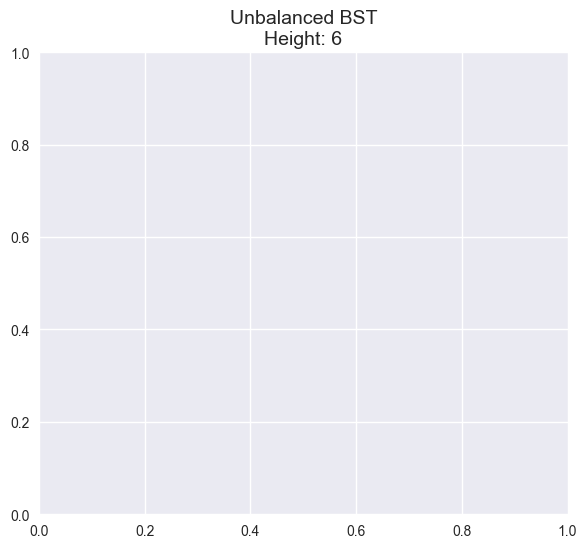

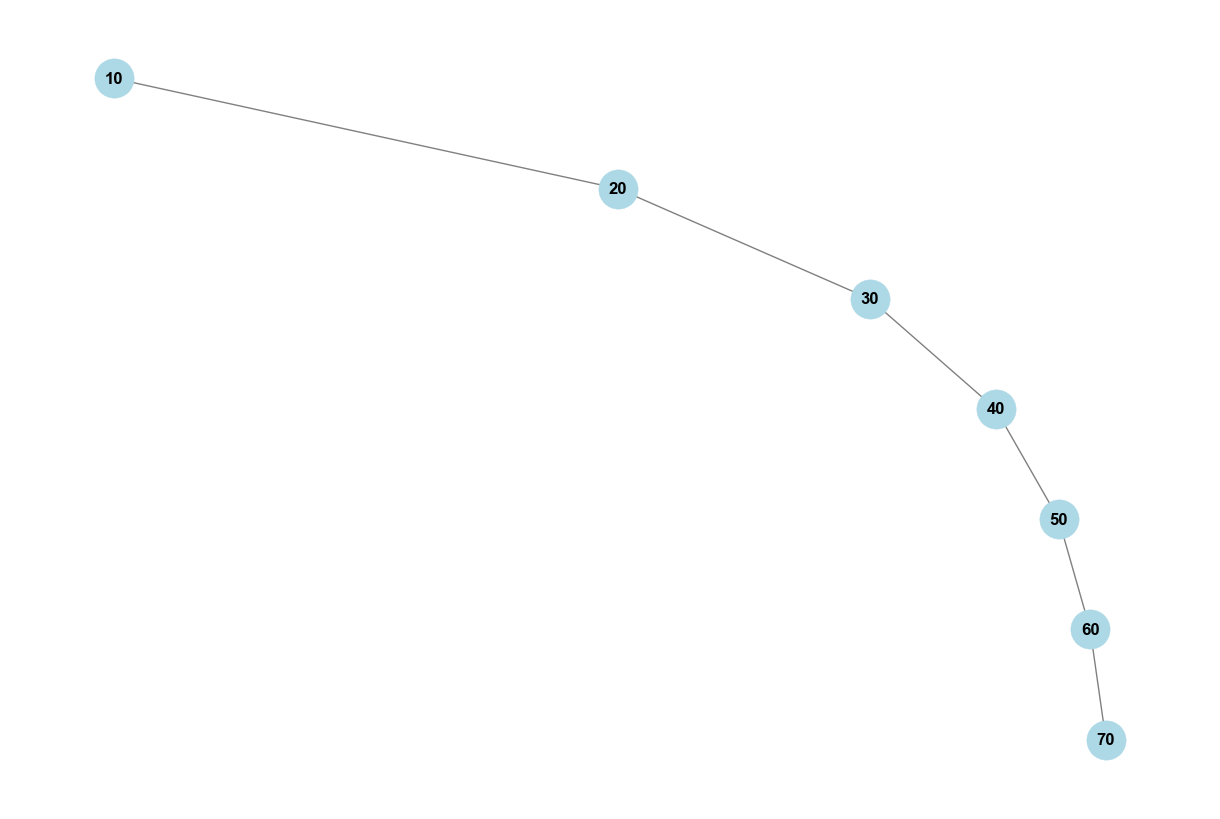

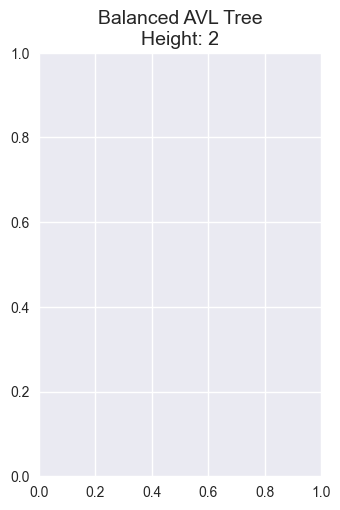

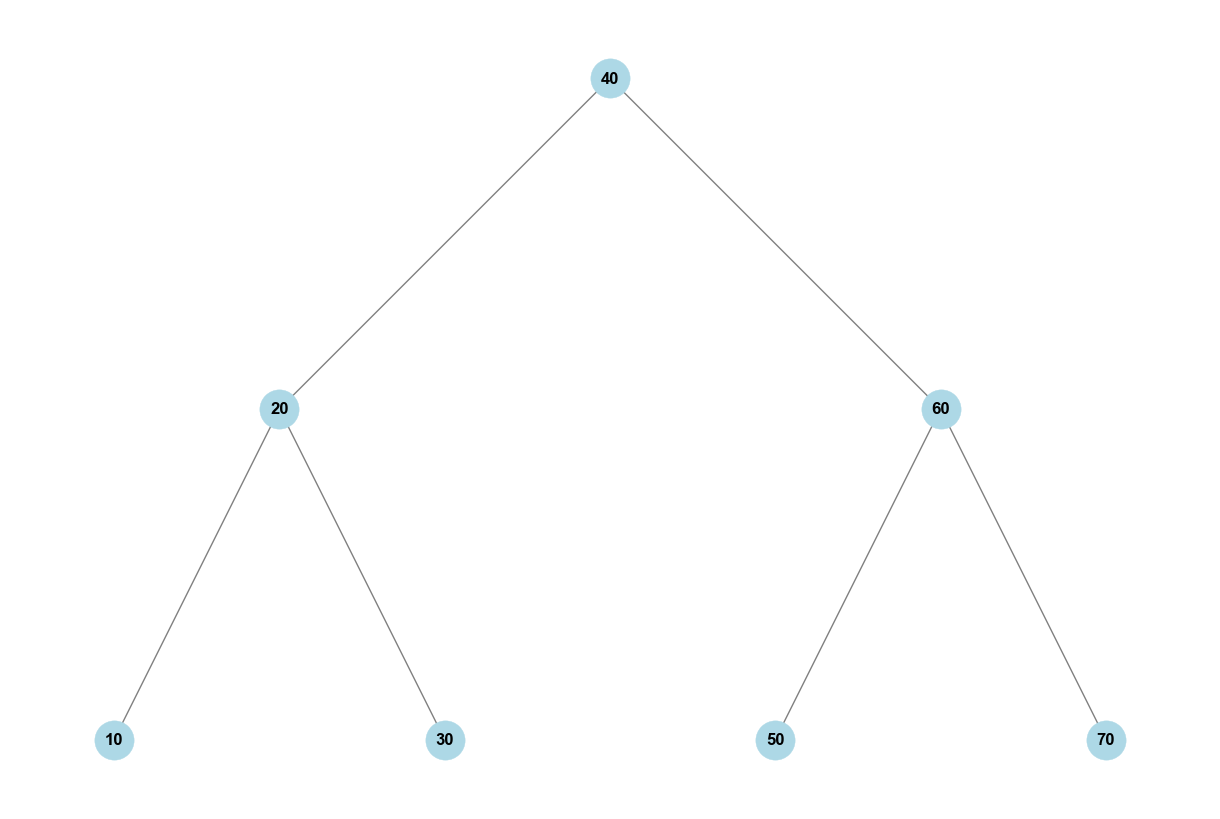

<Figure size 800x550 with 0 Axes>


=== Performance Comparison ===

Size  100: BST height= 11, AVL height=  7, Time ratio: 0.26x
Size  500: BST height= 19, AVL height= 10, Time ratio: 0.25x
Size 1000: BST height= 21, AVL height= 11, Time ratio: 1.45x

=== AVL Rotations Demonstration ===

LL Rotation (Right rotation):
  Insert 30: height = 0
  Insert 20: height = 1
  Insert 10: height = 1

RR Rotation (Left rotation):
  Insert 10: height = 0
  Insert 20: height = 1
  Insert 30: height = 1

LR Rotation (Left-right double rotation):
  Insert 30: height = 0
  Insert 10: height = 1
  Insert 20: height = 1

🎯 Key Insights:
- AVL trees guarantee O(log n) performance
- Rotations maintain balance after insertions/deletions
- Height stays within 45% of optimal
- Balance factor ensures no subtree is too unbalanced
- Extra space and time for rotations vs regular BSTs


In [6]:
# Interactive AVL tree demonstration
print("=== AVL TREES - SELF-BALANCING BSTs ===\n")

# Compare BST vs AVL
bst_unbalanced = BinarySearchTree()
avl_balanced = AVLTree()

# Insert values that cause imbalance in BST
problematic_values = [10, 20, 30, 40, 50, 60, 70]  # Creates right-skewed BST

print("Comparing BST vs AVL with sequential insertions:")
print("Values:", problematic_values)
print()

# Insert step by step
for i, val in enumerate(problematic_values, 1):
    bst_unbalanced.insert(val)
    avl_balanced.insert(val)
    
    print(f"After inserting {val}:")
    print(f"  BST  - Height: {bst_unbalanced.get_height()}, Size: {bst_unbalanced.count_nodes()}")
    print(f"  AVL  - Height: {avl_balanced.get_height()}, Size: {avl_balanced.count_nodes()}")
    print()

# Final comparison
print("Final Comparison:")
print(f"BST Height: {bst_unbalanced.get_height()} (O(n) worst case)")
print(f"AVL Height: {avl_balanced.get_height()} (O(log n) guaranteed)")
print(f"Height Ratio: {bst_unbalanced.get_height()/avl_balanced.get_height():.1f}x")

# Visualize both trees
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title(f"Unbalanced BST\nHeight: {bst_unbalanced.get_height()}", fontsize=14)
plot_tree(bst_unbalanced, "")

plt.subplot(1, 2, 2)
plt.title(f"Balanced AVL Tree\nHeight: {avl_balanced.get_height()}", fontsize=14)
plot_tree(avl_balanced, "")

plt.tight_layout()
plt.show()

# Performance comparison
print("\n=== Performance Comparison ===\n")

# Test with larger dataset
test_sizes = [100, 500, 1000]

for size in test_sizes:
    # Generate random values
    values = [random.randint(0, size*10) for _ in range(size)]
    
    # Test BST
    bst_test = BinarySearchTree()
    start = time.time()
    for v in values:
        bst_test.insert(v)
    bst_time = time.time() - start
    
    # Test AVL
    avl_test = AVLTree()
    start = time.time()
    for v in values:
        avl_test.insert(v)
    avl_time = time.time() - start
    
    print(f"Size {size:4}: BST height={bst_test.get_height():3}, "
          f"AVL height={avl_test.get_height():3}, "
          f"Time ratio: {bst_time/avl_time:.2f}x")

# Demonstrate rotations
print("\n=== AVL Rotations Demonstration ===\n")

def demonstrate_rotations():
    """Show different rotation scenarios."""
    
    # LL Case
    print("LL Rotation (Right rotation):")
    ll_tree = AVLTree()
    ll_values = [30, 20, 10]  # Creates left-left imbalance
    for v in ll_values:
        ll_tree.insert(v)
        print(f"  Insert {v}: height = {ll_tree.get_height()}")
    
    # RR Case
    print("\nRR Rotation (Left rotation):")
    rr_tree = AVLTree()
    rr_values = [10, 20, 30]  # Creates right-right imbalance
    for v in rr_values:
        rr_tree.insert(v)
        print(f"  Insert {v}: height = {rr_tree.get_height()}")
    
    # LR Case
    print("\nLR Rotation (Left-right double rotation):")
    lr_tree = AVLTree()
    lr_values = [30, 10, 20]  # Creates left-right imbalance
    for v in lr_values:
        lr_tree.insert(v)
        print(f"  Insert {v}: height = {lr_tree.get_height()}")

demonstrate_rotations()

print("\n🎯 Key Insights:")
print("- AVL trees guarantee O(log n) performance")
print("- Rotations maintain balance after insertions/deletions")
print("- Height stays within 45% of optimal")
print("- Balance factor ensures no subtree is too unbalanced")
print("- Extra space and time for rotations vs regular BSTs")

In [7]:
# Interactive tree operations explorer
def create_tree_operations_explorer():
    """Interactive tree operations with BST and AVL comparison."""
    
    tree_type_selector = widgets.Dropdown(
        options=['Binary Search Tree', 'AVL Tree'],
        value='Binary Search Tree',
        description='Tree Type:'
    )
    
    operation_selector = widgets.Dropdown(
        options=['Insert', 'Search', 'Delete', 'Find Min/Max'],
        value='Insert',
        description='Operation:'
    )
    
    value_input = widgets.IntText(
        value=42,
        description='Value:',
        continuous_update=False
    )
    
    output_area = widgets.Output()
    tree_area = widgets.Output()
    
    # Global tree instances
    bst_tree = BinarySearchTree()
    avl_tree = AVLTree()
    
    def get_current_tree():
        """Get the currently selected tree instance."""
        if tree_type_selector.value == 'Binary Search Tree':
            return bst_tree
        else:
            return avl_tree
    
    def perform_operation(b):
        with output_area:
            clear_output(wait=True)
            
            tree = get_current_tree()
            operation = operation_selector.value
            value = value_input.value
            
            print(f"{tree_type_selector.value} - {operation} Operation")
            print("=" * 50)
            
            try:
                if operation == 'Insert':
                    success = tree.insert(value)
                    if success:
                        print(f"✅ Inserted {value}")
                        print(f"New height: {tree.get_height()}")
                        print(f"New size: {tree.count_nodes()}")
                        
                        if hasattr(tree, 'is_balanced'):
                            print(f"Is balanced: {tree.is_balanced()}")
                    else:
                        print(f"❌ {value} already exists")
                    
                elif operation == 'Search':
                    found, path = tree.search_with_path(value)
                    if found:
                        print(f"✅ Found {value}")
                        print(f"Search path: {path}")
                    else:
                        print(f"❌ {value} not found")
                        if path:
                            print(f"Search path: {path}")
                    
                elif operation == 'Delete':
                    success = tree.delete(value)
                    if success:
                        print(f"✅ Deleted {value}")
                        print(f"New height: {tree.get_height()}")
                        print(f"New size: {tree.count_nodes()}")
                    else:
                        print(f"❌ {value} not found")
                    
                else:  # Find Min/Max
                    min_val = tree.find_min()
                    max_val = tree.find_max()
                    print(f"Minimum value: {min_val}")
                    print(f"Maximum value: {max_val}")
                
                # Show current tree stats
                print(f"\nTree Status:")
                print(f"Height: {tree.get_height()}")
                print(f"Size: {tree.count_nodes()}")
                if hasattr(tree, 'is_balanced'):
                    print(f"Is balanced: {tree.is_balanced()}")
                
            except Exception as e:
                print(f"Error: {e}")
    
    def visualize_current_tree(b):
        with tree_area:
            clear_output(wait=True)
            
            tree = get_current_tree()
            
            plt.figure(figsize=(10, 6))
            
            if tree.root is None:
                plt.text(0.5, 0.5, 'Empty Tree\n\nUse Insert to add nodes', 
                        ha='center', va='center', fontsize=14)
                plt.xlim(0, 1)
                plt.ylim(0, 1)
                plt.axis('off')
            else:
                tree_type = tree_type_selector.value
                title = f"{tree_type} Structure\nHeight: {tree.get_height()}, Size: {tree.count_nodes()}"
                plot_tree(tree, title)
            
            plt.show()
    
    # Event handlers
    def on_tree_type_change(change):
        """Update visualization when tree type changes."""
        visualize_current_tree(None)
    
    tree_type_selector.observe(on_tree_type_change, names='value')
    
    operate_button = widgets.Button(description='Execute Operation')
    operate_button.on_click(perform_operation)
    
    visualize_button = widgets.Button(description='Visualize Tree')
    visualize_button.on_click(visualize_current_tree)
    
    # Layout
    controls = widgets.VBox([
        widgets.HBox([tree_type_selector, operation_selector]),
        widgets.HBox([value_input, operate_button, visualize_button])
    ])
    
    display(widgets.VBox([controls, widgets.HBox([output_area, tree_area])]))
    
    # Initial visualization
    perform_operation(None)
    visualize_current_tree(None)

print("🌳 Interactive Tree Operations Explorer")
print("Compare BST and AVL tree operations side by side:")
create_tree_operations_explorer()

🌳 Interactive Tree Operations Explorer
Compare BST and AVL tree operations side by side:


## 📋 Summary & Key Takeaways

### Tree Data Structure Comparison

| Property | Binary Tree | BST | AVL Tree |
|----------|-------------|-----|----------|
| **Ordering** | None | Left < Node < Right | Left < Node < Right |
| **Balance** | Unconstrained | Unconstrained | |BF| ≤ 1 |
| **Height** | O(n) worst | O(n) worst | O(log n) guaranteed |
| **Search** | O(n) | O(n) worst, O(log n) avg | O(log n) |
| **Insert** | O(n) | O(n) worst, O(log n) avg | O(log n) |
| **Space** | O(n) | O(n) | O(n) |
| **Use Case** | General hierarchy | Ordered data | Guaranteed performance |

### When to Use Each Tree Type

- **Binary Tree**: General hierarchical data, custom traversals
- **BST**: Ordered data with good average performance
- **AVL Tree**: Ordered data requiring guaranteed O(log n) performance
- **B-Tree**: Database indexes (disk-based, multi-way)
- **Trie**: String/lexical data (prefix trees)
- **Heap**: Priority queues (different invariants)

### Performance Trade-offs

**BST Advantages:**
- Simple implementation
- Memory efficient
- Good average performance

**BST Disadvantages:**
- Unpredictable performance
- Degenerates to linked list
- Worst case O(n) operations

**AVL Advantages:**
- Guaranteed O(log n) performance
- Predictable behavior
- Height-balanced

**AVL Disadvantages:**
- Complex rotations
- Extra space for balance factors
- Slightly slower constants

### Implementation Considerations

- **Recursive vs Iterative**: Recursion can cause stack overflow
- **Parent Pointers**: Simplify deletions but use extra space
- **Balance Maintenance**: Rotations preserve BST property
- **Memory Layout**: Affects cache performance

### Real-World Applications

- **File Systems**: Directory hierarchies
- **Databases**: Index structures, B-Trees
- **Compilers**: Symbol tables
- **AI**: Decision trees, game trees
- **Networks**: Routing tables, IP lookups
- **Text Processing**: Tries for autocomplete

## 🧪 Practice Challenges

1. **Tree Construction**: Build trees from different traversal orders
2. **BST Validation**: Check if a binary tree is a valid BST
3. **Tree Serialization**: Convert trees to/from strings
4. **Lowest Common Ancestor**: Find LCA in BST vs binary tree
5. **Tree Isomorphism**: Check if two trees have the same structure

**Remember**: Trees are fundamental to computer science - master them and you'll understand hierarchical data everywhere! 🌳